<a id='top'></a>
# How to slice and dice the data
Below are a series of examples on how to slice and dice the data that is stored in the *.sqlite* file generated by the [MorningStar.com](https://www.morningstar.com) scraper. 

##### NOTE: 
- The data used to generate the codes below comes from the *.sqlite* that is generated by the scraper once it has been installed and ran locally on your machine. See the [README]() for instructions on how to run install and run the scraper.
- Navigation links as the ones in the list of content below as well as other links throught this document will only work if you are using [Jupyter](https://jupyter.org/) to view this document.


**Content** 

1. [Required modules and matplotlib backend](#modules)
1. [Creating a master (bridge table) DataFrame instance using the DataFrames class](#master)
1. [Creating DataFrame instances with the dataframes methods](#methods)
1. [Data statistics and sample code](#stats)
1. [Applying value investing criteria to filter common stocks](#value) *(in progress)*
1. [Additional sample / test code](#additional) *(in progress)*

<a id="modules"></a>
## Required modules and matplotlib backend

In [76]:
%matplotlib notebook

In [77]:
import matplotlib.pyplot as plt
import matplotlib

In [78]:
from importlib import reload
import pandas as pd
import numpy as np

# Import dataframes module from project folder.
# This module contains a class that reads the database tables and assigns the data to pandas.DataFrame objects
import dataframes
reload(dataframes) #reload if changes have been made to module file

<module 'dataframes' from '/home/cbrandao/lib/python/msTables/dataframes.py'>

[return to the top](#top)
<a id="master"></a>
## Creating a master DataFrame instance using the dataframes class
The DataFrames class is part of the [dataframes module](dataframes.py)

In [79]:
db_file_name = 'mstables2' # Change the file name here as needed
df = dataframes.DataFrames('db/{}.sqlite'.format(db_file_name))

Creating intial DataFrames from file db/mstables2.sqlite...
Creating DataFrame 'colheaders' ...
Creating DataFrame 'timerefs' ...
Creating DataFrame 'urls' ...
Creating DataFrame 'securitytypes' ...
Creating DataFrame 'tickers' ...
Creating DataFrame 'sectors' ...
Creating DataFrame 'industries' ...
Creating DataFrame 'stockstyles' ...
Creating DataFrame 'exchanges' ...
Creating DataFrame 'countries' ...
Creating DataFrame 'companies' ...
Creating DataFrame 'currencies' ...
Creating DataFrame 'stocktypes' ...
Creating DataFrame 'master' ...
Initial DataFrames created.


### Creating Master DataFrame instance from reference tables
By merging `df.master` (*Master* bridge table) with other reference tables (e.g. `df.tickers`, `df.exchanges`, etc.)
##### DataFrame Instance

In [80]:
# Merge Tables
df_master0 = (df.master
# Ticker Symbols
 .merge(df.tickers, left_on='ticker_id', right_on='id').drop(['id'], axis=1)
# Company / Security Name
 .merge(df.companies, left_on='company_id', right_on='id').drop(['id', 'company_id'], axis=1)
# Exchanges
 .merge(df.exchanges, left_on='exchange_id', right_on='id').drop(['id'], axis=1)
# Industries
 .merge(df.industries, left_on='industry_id', right_on='id').drop(['id', 'industry_id'], axis=1)
# Sectors
 .merge(df.sectors, left_on='sector_id', right_on='id').drop(['id', 'sector_id'], axis=1)
# Countries
 .merge(df.countries, left_on='country_id', right_on='id').drop(['id', 'country_id'], axis=1)
# Security Types
 .merge(df.securitytypes, left_on='security_type_id', right_on='id').drop(['id', 'security_type_id'], axis=1)
# Stock Types
 .merge(df.stocktypes, left_on='stock_type_id', right_on='id').drop(['id', 'stock_type_id'], axis=1)
# Stock Style Types
 .merge(df.styles, left_on='style_id', right_on='id').drop(['id', 'style_id'], axis=1)
# Quote Header Info
 .merge(df.quoteheader(), on=['ticker_id', 'exchange_id']).rename(columns={'fpe':'Forward_PE'})
# Currency
 .merge(df.currencies, left_on='currency_id', right_on='id').drop(['id', 'currency_id'], axis=1)
# Fiscal Year End
 .merge(df.timerefs, left_on='fyend_id', right_on='id').drop(['fyend_id'], axis=1)
             .rename(columns={'dates':'fy_end'})
# Updated Date
 .merge(df.timerefs, left_on='update_date_id', right_on='id').drop(['update_date_id'], axis=1)
             .rename(columns={'dates':'updated_date'})
)

# Change date columns to TimeFrames
df_master0['fy_end'] = pd.to_datetime(df_master0['fy_end'])
df_master0['updated_date'] = pd.to_datetime(df_master0['updated_date'])

# Create df_master and apply filters
df_master = df_master0.copy()

df_master[['lastprice', 'day_hi', 'day_lo', '_52wk_hi', '_52wk_lo', 'yield', 'aprvol', 'avevol']] = (
    df_master[['lastprice', 'day_hi', 'day_lo', '_52wk_hi', '_52wk_lo', 'yield', 'aprvol', 'avevol']]
    .fillna(value=0.0))

df_master = (df_master.where((df_master['openprice'] > 0.0) & (df_master['lastprice'] > 0.0))
             .dropna(axis=0, how='all'))

In [81]:
df_master.head()

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,country_c2,...,aprvol,avevol,Forward_PE,pb,ps,pc,currency,currency_code,fy_end,updated_date
0,1.0,374.0,OGCP,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,8736.0,3548.0,NaN,2.4,6.4,16.9,United States Dollar,USD,2019-12-31,2019-03-27
1,2.0,374.0,FISK,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,1389.0,2647.0,NaN,2.4,6.4,16.8,United States Dollar,USD,2019-12-31,2019-03-27
2,3.0,374.0,ESBA,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,17845.0,21680.0,NaN,2.3,6.3,16.6,United States Dollar,USD,2019-12-31,2019-03-27
3,18686.0,302.0,ARE,Alexandria Real Estate Equities Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,416784.0,721792.0,56.2,2.2,11.0,25.7,United States Dollar,USD,2019-12-31,2019-03-27
4,19275.0,302.0,LPT,Liberty Property Trust,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,627477.0,887562.0,NaN,2.1,10.1,18.7,United States Dollar,USD,2019-12-31,2019-03-27


##### DataFrame Length

In [82]:
print('Master DataFrame contains {:,.0f} records.'.format(len(df_master)))

Master DataFrame contains 103,507 records.


##### DataFrame Columns

In [83]:
df_master.columns

Index(['ticker_id', 'exchange_id', 'ticker', 'company', 'exchange',
       'exchange_sym', 'industry', 'sector', 'country', 'country_c2',
       'country_c3', 'security_type_code', 'security_type', 'stock_type',
       'style', 'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi',
       '_52wk_lo', 'yield', 'aprvol', 'avevol', 'Forward_PE', 'pb', 'ps', 'pc',
       'currency', 'currency_code', 'fy_end', 'updated_date'],
      dtype='object')

<br></br>
[return to the top](#top)
<a id='methods'></a>
## Creating DataFrame instances with dataframes methods
Class DataFrames from [dataframe.py](dataframe.py) contains the following methods that return a pd.DataFrame object for the specified database table:

- `quoteheader` - [MorningStar (MS) Quote Header](#quote)
- `valuation` - [MS Valuation table with Price Ratios (P/E, P/S, P/B, P/C) for the past 10 yrs](#val)
- `keyratios` - [MS Ratio - Key Financial Ratios & Values](#keyratios)
- `finhealth` - [MS Ratio - Financial Health](#finhealth)
- `profitability` - [MS Ratio - Profitability](#prof)
- `growth` - [MS Ratio - Growth](#growth)
- `cfhealth` - [MS Ratio - Cash Flow Health](#cfh)
- `efficiency` - [MS Ratio - Efficiency](#eff)
- `annualIS` - [MS Annual Income Statements](#isa)
- `quarterlyIS` - [MS Quarterly Income Statements](#isq)
- `annualBS` - [MS Annual Balance Sheets](#bsa)
- `quarterlyBS` - [MS Quarterly Balance Sheets](#bsq)
- `annualCF` - [MS Annual Cash Flow Statements](#cfa)
- `quarterlyCF` - [MS Quarterly Cash Flow Statements](#cfq)
- `pricehistory` - MSpricehistory

[return to the top](#top)
<a id='quote'></a>
### Quote Header 
##### DataFrame Instance

In [9]:
df_quote = df.quoteheader()

In [10]:
df_quote.head()

,ticker_id,exchange_id,openprice,lastprice,day_hi,day_lo,_52wk_hi,_52wk_lo,yield,aprvol,avevol,fpe,pb,ps,pc,currency_id
0,1,374,15.84,15.82,15.84,15.82,17.72,12.16,2.65,8736.0,3548.0,NaN,2.4,6.4,16.9,104.0
1,2,374,15.73,15.73,15.73,15.73,17.68,13.68,2.67,1389.0,2647.0,NaN,2.4,6.4,16.8,104.0
2,3,374,15.65,15.72,15.72,15.56,17.79,11.99,2.69,17845.0,21680.0,NaN,2.3,6.3,16.6,104.0
3,4,482,94.99,94.77,95.22,93.06,115.36,87.87,1.26,933703.0,819856.0,19.6,3.3,3.9,20.0,104.0
4,5,1,0.00,0,0,0,0,0,NaN,184.0,184.0,NaN,NaN,NaN,NaN,104.0


##### DataFrame Length

In [11]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quote)))

DataFrame contains 117,590 records.


<a id='val'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Price Ratios (P/E, P/S, P/B, P/C)
##### DataFrame Instance

In [84]:
df_vals = df.valuation()

In [85]:
df_vals

PE_2009  PE_2010  PE_2011  PE_2012  PE_2013  PE_2014  \
exchange_id ticker_id                                                         
374         1              NaN      NaN      NaN      NaN      NaN     18.6   
            2              NaN      NaN      NaN      NaN      NaN     18.2   
            3              NaN      NaN      NaN      NaN      NaN     18.3   
482         4              NaN     22.2     17.4     16.6     27.0     29.7   
1           5              NaN      NaN      NaN      NaN      NaN      NaN   
            6              NaN      NaN      NaN      NaN      NaN      NaN   
            7              NaN      NaN      NaN      NaN      NaN      NaN   
            8              NaN      NaN      NaN      NaN      NaN      NaN   
            9              NaN      NaN      NaN      NaN      NaN      NaN   
            10             NaN      NaN      NaN      NaN      1.1      NaN   
            11             NaN      NaN      NaN      NaN      NaN      NaN   
            12             NaN      NaN      NaN      NaN      NaN      NaN   
            13             NaN     28.7     50.0      NaN      NaN      NaN   
            14             8.8     10.9      2.8      NaN      NaN      NaN   
            15             NaN      NaN      NaN      NaN      NaN      NaN   
            16             NaN      NaN      NaN      NaN      NaN      NaN   
            17             NaN      1.2      0.3      NaN      NaN      NaN   
            18             NaN      NaN      NaN      NaN      NaN      NaN   
            19             NaN      NaN      NaN      NaN      NaN      NaN   
            20             NaN      NaN      NaN      NaN      NaN      NaN   
            21             NaN      NaN      NaN      NaN      NaN      NaN   
            22             NaN      NaN      NaN      NaN      NaN      NaN   
            23             2.5      5.0      NaN      6.0      NaN     19.7   
            24             NaN      NaN      NaN      NaN      NaN      NaN   
            25             NaN      NaN      NaN      NaN      NaN      NaN   
            26             NaN      NaN      NaN      NaN      NaN      NaN   
            27             NaN      NaN      NaN      NaN      NaN      NaN   
            28             NaN      NaN      NaN      NaN      NaN      NaN   
            29             NaN      NaN      NaN      NaN      NaN      NaN   
            30             NaN      NaN      NaN      NaN      NaN      NaN   
...                        ...      ...      ...      ...      ...      ...   
563         3964860        NaN      NaN      NaN      NaN      NaN      NaN   
569         3964865        NaN      NaN      NaN      NaN      NaN     32.8   
26          3964889        NaN      NaN      NaN      NaN      NaN      NaN   
563         3964899        NaN      NaN      NaN      NaN      NaN     17.2   
26          3964915        NaN      NaN      2.8      1.3      3.9      6.7   
            3964917        NaN      NaN      NaN      NaN      NaN      NaN   
            3964921        NaN      NaN      4.1      6.6      6.8      9.6   
            3964925        NaN      NaN      NaN      NaN      NaN      NaN   
            3964928       97.1     22.9     43.5      NaN      NaN      NaN   
            3964931        NaN      NaN      NaN      NaN      NaN      NaN   
            3964932      212.8      NaN      NaN      0.0     48.3      NaN   
            3964940        NaN      NaN      NaN      NaN      NaN      NaN   
433         3965518        NaN      NaN      5.0      NaN      NaN      NaN   
16          3965533        NaN      NaN      NaN    161.3      NaN      NaN   
17          3965533        NaN      NaN    102.0    161.3      NaN      NaN   
141         3965533        NaN      NaN      NaN      NaN      NaN      NaN   
144         3965533        NaN      NaN      NaN      NaN      NaN      NaN   
16          3965537        NaN      NaN      NaN      NaN      NaN      N

##### DataFrame Length

In [52]:
print('DataFrame contains {:,.0f} records.'.format(len(df_vals)))

DataFrame contains 79,934 records.


##### DataFrame Columnns

In [53]:
df_vals.columns

Index(['exchange_id', 'ticker_id', 'PE_2009', 'PE_2010', 'PE_2011', 'PE_2012',
       'PE_2013', 'PE_2014', 'PE_2015', 'PE_2016', 'PE_2017', 'PE_2018',
       'PE_TTM', 'PS_2009', 'PS_2010', 'PS_2011', 'PS_2012', 'PS_2013',
       'PS_2014', 'PS_2015', 'PS_2016', 'PS_2017', 'PS_2018', 'PS_TTM',
       'PB_2009', 'PB_2010', 'PB_2011', 'PB_2012', 'PB_2013', 'PB_2014',
       'PB_2015', 'PB_2016', 'PB_2017', 'PB_2018', 'PB_TTM', 'PC_2009',
       'PC_2010', 'PC_2011', 'PC_2012', 'PC_2013', 'PC_2014', 'PC_2015',
       'PC_2016', 'PC_2017', 'PC_2018', 'PC_TTM'],
      dtype='object')

<a id='keyratios'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Key Ratios
##### DataFrame Instance

In [54]:
df_keyratios = (df_master.merge(df.keyratios(), on=['ticker_id', 'exchange_id']))

In [55]:
df_keyratios.head()

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,country_c2,...,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
0,1.0,374.0,OGCP,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
1,2.0,374.0,FISK,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
2,3.0,374.0,ESBA,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
3,18686.0,302.0,ARE,Alexandria Real Estate Equities Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
4,19275.0,302.0,LPT,Liberty Property Trust,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM


##### DataFrame Length

In [18]:
print('DataFrame contains {:,.0f} records.'.format(len(df_keyratios)))

DataFrame contains 68,307 records.


##### DataFrame Columnns

In [19]:
df_labels_kratios = (df_keyratios
                     .loc[0, [col for col in df_keyratios.columns if 'Y' not in col and col.startswith('i')]]
                     .replace(df.colheaders['header']))
df_labels_kratios

industry          REIT - Diversified
i0                           Revenue
i1                      Gross_Margin
i2                  Operating_Income
i3                  Operating_Margin
i4                        Net_Income
i5                Earnings_Per_Share
i6                         Dividends
i91                     Payout_Ratio
i7                            Shares
i8              Book_Value_Per_Share
i9               Operating_Cash_Flow
i10                     Cap_Spending
i11                   Free_Cash_Flow
i90         Free_Cash_Flow_Per_Share
i80                  Working_Capital
Name: 0, dtype: object

<a id='finhealth'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Financial Health
##### DataFrame Instance

In [20]:
df_finhealth = df.finhealth()

In [21]:
df_finhealth.head()

,ticker_id,exchange_id,fh_balsheet,fh_Y0,fh_Y1,fh_Y2,fh_Y3,fh_Y4,fh_Y5,fh_Y6,...,i68_lfh_Y1,i68_lfh_Y2,i68_lfh_Y3,i68_lfh_Y4,i68_lfh_Y5,i68_lfh_Y6,i68_lfh_Y7,i68_lfh_Y8,i68_lfh_Y9,i68_lfh_Y10
0,1,374,324,40,41,42,43,44,11,12,...,NaN,NaN,NaN,1.2,1.17,1.19,0.81,0.85,0.96,0.96
1,2,374,324,40,41,42,43,44,11,12,...,NaN,NaN,NaN,1.2,1.17,1.19,0.81,0.85,0.96,0.96
2,3,374,324,40,41,42,43,44,11,12,...,NaN,NaN,NaN,1.2,1.17,1.19,0.81,0.85,0.96,0.96
3,4,482,324,40,41,42,43,44,11,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40,0.28,0.28
4,5,1,324,697,698,699,700,701,668,669,...,NaN,NaN,NaN,NaN,4.34,3.53,2.07,NaN,0.28,1.34


##### DataFrame Length

In [22]:
print('DataFrame contains {:,.0f} records.'.format(len(df_finhealth)))

DataFrame contains 77,177 records.


##### DataFrame Columns

In [23]:
(df_finhealth.loc[0, [col for col in df_finhealth.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

fh_balsheet         Balance Sheet Items (in %)
i45              Cash & Short-Term Investments
i46                        Accounts Receivable
i47                                  Inventory
i48                       Other Current Assets
i49                       Total Current Assets
i50                                   Net PP&E
i51                                Intangibles
i52                     Other Long-Term Assets
i53                               Total Assets
i54                           Accounts Payable
i55                            Short-Term Debt
i56                              Taxes Payable
i57                        Accrued Liabilities
i58               Other Short-Term Liabilities
i59                  Total Current Liabilities
i60                             Long-Term Debt
i61                Other Long-Term Liabilities
i62                          Total Liabilities
i63                  Total Stockholders Equity
i64                 Total Liabilities & Equity
lfh_liquidity

<a id='prof'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Profitability
##### DataFrame Instance

In [24]:
df_profitability = df.profitability()

In [25]:
df_profitability.head()

,ticker_id,exchange_id,pr_margins,pr_Y0,pr_Y1,pr_Y2,pr_Y3,pr_Y4,pr_Y5,pr_Y6,...,i95_pr_pro_Y1,i95_pr_pro_Y2,i95_pr_pro_Y3,i95_pr_pro_Y4,i95_pr_pro_Y5,i95_pr_pro_Y6,i95_pr_pro_Y7,i95_pr_pro_Y8,i95_pr_pro_Y9,i95_pr_pro_Y10
0,1,374,279,40,41,42,43,44,11,12,...,NaN,2.05,1.89,4.52,2.13,2.24,2.59,2.82,2.53,2.53
1,2,374,279,40,41,42,43,44,11,12,...,NaN,2.05,1.89,4.52,2.13,2.24,2.59,2.82,2.53,2.53
2,3,374,279,40,41,42,43,44,11,12,...,NaN,2.05,1.89,4.52,2.13,2.24,2.59,2.82,2.53,2.53
3,4,482,279,40,41,42,43,44,11,12,...,184.73,274.13,NaN,NaN,NaN,NaN,NaN,8.85,15.10,15.10
4,5,1,279,697,698,699,700,701,668,669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### DataFrame Length

In [26]:
print('DataFrame contains {:,.0f} records.'.format(len(df_profitability)))

DataFrame contains 77,177 records.


##### DataFrame Columns

In [27]:
# Financial Health DataFrame Columns
(df_profitability.loc[0, [col for col in df_profitability.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

pr_margins              Margins % of Sales
i12                                Revenue
i13                                   COGS
i14                           Gross Margin
i15                                   SG&A
i16                                    R&D
i17                                  Other
i18                       Operating Margin
i19                    Net Int Inc & Other
i20                             EBT Margin
pr_profit                    Profitability
i21                             Tax Rate %
i22                           Net Margin %
i23               Asset Turnover (Average)
i24                     Return on Assets %
i25           Financial Leverage (Average)
i26                     Return on Equity %
i27           Return on Invested Capital %
i95                      Interest Coverage
Name: 0, dtype: object

<a id='growth'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Growth
##### DataFrame Instance

In [28]:
df_growth = df.growth()

KeyboardInterrupt: 

In [ ]:
df_growth.head()

##### DataFrame Length

In [ ]:
print('DataFrame contains {:,.0f} records.'.format(len(df_growth)))

##### DataFrame Columns

In [ ]:
# Financial Health DataFrame Columns
(df_growth.loc[0, [col for col in df_growth.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

<a id='cfh'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Cash Flow Health
##### DataFrame Instance

In [ ]:
df_cfhealth = df.cfhealth()

In [ ]:
df_cfhealth

##### DataFrame Length

In [183]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfhealth)))

DataFrame contains 77,177 records.


##### DataFrame Columns

In [184]:
# Financial Health DataFrame Columns
(df_cfhealth.loc[0, [col for col in df_cfhealth.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

cf_cashflow                    Cash Flow Ratios
i40            Operating Cash Flow Growth % YOY
i41                 Free Cash Flow Growth % YOY
i42                      Cap Ex as a % of Sales
i43                      Free Cash Flow/Sales %
i44                   Free Cash Flow/Net Income
Name: 0, dtype: object

<a id='eff'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Efficiency
##### DataFrame Instance

In [78]:
df_efficiency = df.efficiency()

In [79]:
df_efficiency.head()

,ticker_id,exchange_id,ef_efficiency,ef_Y0,ef_Y1,ef_Y2,ef_Y3,ef_Y4,ef_Y5,ef_Y6,...,i76_ef_Y1,i76_ef_Y2,i76_ef_Y3,i76_ef_Y4,i76_ef_Y5,i76_ef_Y6,i76_ef_Y7,i76_ef_Y8,i76_ef_Y9,i76_ef_Y10
0,1,374,350,40,41,42,43,44,11,12,...,NaN,NaN,0.25,0.18,0.22,0.20,0.19,0.18,0.18,0.18
1,2,374,350,40,41,42,43,44,11,12,...,NaN,NaN,0.25,0.18,0.22,0.20,0.19,0.18,0.18,0.18
2,3,374,350,40,41,42,43,44,11,12,...,NaN,NaN,0.25,0.18,0.22,0.20,0.19,0.18,0.18,0.18
3,4,482,350,40,41,42,43,44,11,12,...,1.06,1.75,1.54,1.46,1.50,1.65,1.53,0.78,0.52,0.52
4,5,1,350,697,698,699,700,701,668,669,...,NaN,NaN,NaN,0.03,0.32,0.22,0.30,NaN,0.03,0.06


##### DataFrame Length

In [80]:
print('DataFrame contains {:,.0f} records.'.format(len(df_efficiency)))

DataFrame contains 77,177 records.


##### DataFrame Columns

In [81]:
# Financial Health DataFrame Columns
(df_efficiency.loc[0, [col for col in df_efficiency.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

ef_efficiency                Efficiency
i69              Days Sales Outstanding
i70                      Days Inventory
i71                     Payables Period
i72               Cash Conversion Cycle
i73                Receivables Turnover
i74                  Inventory Turnover
i75               Fixed Assets Turnover
i76                      Asset Turnover
Name: 0, dtype: object

<a id='isa'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Annual Income Statement
##### DataFrame Instance

In [29]:
df_annualIS0 = df.annualIS()

In [30]:
df_annualIS = (df_master 
 .merge(df_annualIS0, on=['ticker_id', 'exchange_id'])
 .merge(df.timerefs, left_on='Year_Y_6', right_on='id').drop('Year_Y_6', axis=1).rename(columns={'dates':'Y6'})
 .merge(df.timerefs, left_on='Year_Y_5', right_on='id').drop('Year_Y_5', axis=1).rename(columns={'dates':'Y5'})
 .merge(df.timerefs, left_on='Year_Y_4', right_on='id').drop('Year_Y_4', axis=1).rename(columns={'dates':'Y4'})
 .merge(df.timerefs, left_on='Year_Y_3', right_on='id').drop('Year_Y_3', axis=1).rename(columns={'dates':'Y3'})
 .merge(df.timerefs, left_on='Year_Y_2', right_on='id').drop('Year_Y_2', axis=1).rename(columns={'dates':'Y2'})
 .merge(df.timerefs, left_on='Year_Y_1', right_on='id').drop('Year_Y_1', axis=1).rename(columns={'dates':'Y1'})
)
df_annualIS.loc[:, 'Y5':'Y1'] = df_annualIS.loc[:, 'Y5':'Y1'].astype('datetime64')

In [31]:
df_annualIS.head()

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,country_c2,...,label_tts4,label_tts5,currency_id,fye_month,Y6,Y5,Y4,Y3,Y2,Y1
0,1.0,374.0,OGCP,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,104.0,12.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01
1,2.0,374.0,FISK,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,104.0,12.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01
2,3.0,374.0,ESBA,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,104.0,12.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01
3,18686.0,302.0,ARE,Alexandria Real Estate Equities Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,NaN,NaN,NaN,NaN,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01
4,19275.0,302.0,LPT,Liberty Property Trust,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,NaN,NaN,NaN,NaN,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01


##### DataFrame Length

In [32]:
print('DataFrame contains {:,.0f} records.'.format(len(df_annualIS)))

DataFrame contains 68,309 records.


##### DataFrame Columns

In [33]:
labels = [col for col in df_annualIS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualIS[label].unique().tolist() if pd.notna(header)]

df_labels_aIS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_aIS['value'] = df_labels_aIS['value'].replace(df.colheaders['header'])
df_labels_aIS[df_labels_aIS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

df_labels_aIS.sort_values(by='value')

,value
header,
label_i46,Advertising and market...
label_i36,Advertising and market...
label_i15,Advertising and promot...
label_i47,Amortization of intang...
label_i24,Asset impairment
label_i4,Asset mgmt and securit...
label_i85,Basic
label_i83,Basic
label_s2,"Benefits, claims and e..."


<a id='isq'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Quarterly Income Statements
##### DataFrame Instance

In [126]:
df_quarterlyIS0 = df.quarterlyIS()

In [127]:
df_quarterlyIS.head()

NameError: name 'df_quarterlyIS' is not defined

##### DataFrame Length

In [ ]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quarterlyIS)))

##### DataFrame Columns

In [ ]:
labels = [col for col in df_annualIS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualIS[label].unique().tolist() if pd.notna(header)]

df_labels_aIS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_aIS['value'] = df_labels_aIS['value'].replace(df.colheaders['header'])
df_labels_aIS[df_labels_aIS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

df_labels_aIS.sort_values(by='value')

<a id='bsa'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Annual Balance Sheet
##### DataFrame Instance

In [45]:
df_bsa0 = df.annualBS()

In [46]:
df_bsa0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,data_g1_Y_1,data_g1_Y_2,data_g1_Y_3,...,label_ttg2,label_ttg5,label_ttg8,label_ttgg1,label_ttgg2,label_ttgg3,label_ttgg5,label_ttgg6,label_tts1,label_tts2
0,1,374,2014-12,2015-12,2016-12,2017-12,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
1,2,374,2014-12,2015-12,2016-12,2017-12,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
2,3,374,2014-12,2015-12,2016-12,2017-12,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
3,4,482,2014-12,2015-12,2016-12,2017-12,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
4,5,1,2003-12,2004-12,2005-12,2006-06,2007-06,0.0,19946.0,167141.0,...,Total non-current asse...,Total liabilities,Total stockholders eq...,Total cash,"Net property, plant an...",NaN,Total current liabilit...,Total non-current liab...,Total assets,Total liabilities and ...


##### DataFrame Length

In [47]:
print('DataFrame contains {:,.0f} records.'.format(len(df_bsa0)))

DataFrame contains 76,311 records.


##### DataFrame Columns

In [48]:
# Financial Health DataFrame Columns
(df_bsa0.loc[0, [col for col in df_bsa0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g1                             NaN
label_g2                             NaN
label_g5                     Liabilities
label_g8             Stockholders equity
label_gg1                            NaN
label_gg2                            NaN
label_gg3                            NaN
label_gg5                            NaN
label_gg6                            NaN
label_i1          Real estate properties
label_i10                            NaN
label_i11                            NaN
label_i12                            NaN
label_i13                            NaN
label_i14                            NaN
label_i15                            NaN
label_i16                            NaN
label_i17                            NaN
label_i18                            NaN
label_i19                            NaN
label_i2       Accumulated depreciati...
label_i21                            NaN
label_i3       Real estate properties...
label_i30                            NaN
label_i4       C

<a id='bsq'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Quarterly Balance Sheet
##### DataFrame Instance

In [49]:
df_bsq0 = df.quarterlyBS()

In [50]:
df_bsq0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,data_g1_Y_1,data_g1_Y_2,data_g1_Y_3,...,label_ttg2,label_ttg5,label_ttg8,label_ttgg1,label_ttgg2,label_ttgg3,label_ttgg5,label_ttgg6,label_tts1,label_tts2
0,1,374,2017-12,2018-03,2018-06,2018-09,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
1,2,374,2017-12,2018-03,2018-06,2018-09,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
2,3,374,2017-12,2018-03,2018-06,2018-09,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
3,4,482,2017-12,2018-03,2018-06,2018-09,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
4,5,1,2007-03,2007-06,2007-09,2007-12,2008-03,1100958.0,669928.0,272986.0,...,Total non-current asse...,Total liabilities,Total stockholders eq...,Total cash,"Net property, plant an...",NaN,Total current liabilit...,Total non-current liab...,Total assets,Total liabilities and ...


##### DataFrame Length

In [51]:
print('DataFrame contains {:,.0f} records.'.format(len(df_bsq0)))

DataFrame contains 76,216 records.


##### DataFrame Columns

In [52]:
# Financial Health DataFrame Columns
(df_bsq0.loc[0, [col for col in df_bsq0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g1                             NaN
label_g2                             NaN
label_g5                     Liabilities
label_g8             Stockholders equity
label_gg1                            NaN
label_gg2                            NaN
label_gg3                            NaN
label_gg5                            NaN
label_gg6                            NaN
label_i1          Real estate properties
label_i10                            NaN
label_i11                            NaN
label_i12                            NaN
label_i13                            NaN
label_i14                            NaN
label_i15                            NaN
label_i16                            NaN
label_i17                            NaN
label_i18                            NaN
label_i19                            NaN
label_i2       Accumulated depreciati...
label_i21                            NaN
label_i3       Real estate properties...
label_i30                            NaN
label_i4       C

<a id='cfa'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Annual Cash Flow Statement
##### DataFrame Instance

In [133]:
df_cfa0 = df.annualCF()

In [134]:
df_cfa0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6,data_i1_Y_1,data_i1_Y_2,...,label_i98,label_i99,label_s1,label_s2,label_s3,label_tts1,label_tts2,label_tts3,currency_id,fye_month
0,1,374,11,12,13,1,5,21,NaN,NaN,...,143.0,144.0,88,109,121,108,120,133,104.0,12.0
1,2,374,11,12,13,1,5,21,NaN,NaN,...,143.0,144.0,88,109,121,108,120,133,104.0,12.0
2,3,374,11,12,13,1,5,21,NaN,NaN,...,143.0,144.0,88,109,121,108,120,133,104.0,12.0
3,4,482,11,12,13,1,5,21,NaN,NaN,...,143.0,144.0,88,109,121,108,120,133,104.0,12.0
4,5,1,668,669,670,671,664,21,-129926.0,-209185.0,...,NaN,NaN,88,109,121,108,120,133,104.0,6.0


##### DataFrame Length

In [135]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfa0)))

DataFrame contains 76,767 records.


##### DataFrame Columns

In [136]:
# Financial Health DataFrame Columns
(df_cfa0.loc[0, [col for col in df_cfa0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g7                 Free Cash Flow
label_g8      Supplemental schedule ...
label_i1                     Net income
label_i10     Stock based compensati...
label_i100          Operating cash flow
label_i11                           NaN
label_i12                           NaN
label_i13                           NaN
label_i15                           NaN
label_i16           Accounts receivable
label_i17                     Inventory
label_i18              Prepaid expenses
label_i19              Accounts payable
label_i2      Depreciation & amortiz...
label_i20           Accrued liabilities
label_i21              Interest payable
label_i22          Income taxes payable
label_i23         Other working capital
label_i24                           NaN
label_i25                           NaN
label_i26                           NaN
label_i27                           NaN
label_i28                           NaN
label_i29                           NaN
label_i3      Amortization of debt d...


<a id='cfq'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Quarterly Cash Flow Statement
##### DataFrame Instance

In [57]:
df_cfq0 = df.quarterlyCF()

In [58]:
df_cfq0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6,data_i1_Y_1,data_i1_Y_2,...,label_i96,label_i97,label_i98,label_i99,label_s1,label_s2,label_s3,label_tts1,label_tts2,label_tts3
0,1,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
1,2,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
2,3,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
3,4,482,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
4,5,1,2007-03,2007-06,2007-09,2007-12,2008-03,TTM,-429976.0,-980707.0,...,Capital expenditure,Free cash flow,NaN,NaN,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...


##### DataFrame Length

In [59]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfq0)))

DataFrame contains 76,331 records.


##### DataFrame Columns

In [60]:
# Financial Health DataFrame Columns
(df_cfq0.loc[0, [col for col in df_cfq0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g7                 Free Cash Flow
label_g8      Supplemental schedule ...
label_i1                     Net income
label_i10     Stock based compensati...
label_i100          Operating cash flow
label_i11                           NaN
label_i12                           NaN
label_i13                           NaN
label_i15                           NaN
label_i16           Accounts receivable
label_i17                     Inventory
label_i18              Prepaid expenses
label_i19              Accounts payable
label_i2      Depreciation & amortiz...
label_i20           Accrued liabilities
label_i21              Interest payable
label_i22          Income taxes payable
label_i23         Other working capital
label_i24                           NaN
label_i25                           NaN
label_i26                           NaN
label_i27                           NaN
label_i28                           NaN
label_i29                           NaN
label_i3      Amortization of debt d...


<a id="stats"></a>
[return to list of methods](#methods),
[return to the top](#top)
## Below are a few statistics on database data

### Count of database records
**1.** Total number of records **before** merging reference tables *(length of `df.master`)*

In [29]:
print('DataFrame df.master contains {:,.0f} records.'.format(len(df.master)))

DataFrame df.master contains 117,711 records.


**2.** Total number of records **after** merging reference tables *(length of `df_master`)*

In [30]:
print('DataFrame df_master0 contains {:,.0f} records.'.format(len(df_master0)))

DataFrame df_master0 contains 112,157 records.


**3.** Total number of records **after** merging reference tables where the following filters apply:
- $openprice > 0$
- $lastprice > 0$

In [31]:
print('DataFrame df_master contains {:,.0f} records.'.format(len(df_master)))

DataFrame df_master contains 103,507 records.


### Last updated dates
List of dates (as a pd.Series object) of when the database records were last updated. 
The values indicate the number of records updated on each date.

In [33]:
(df_master[['updated_date', 'ticker']].groupby(by='updated_date').count().sort_index(ascending=False)
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
updated_date,
2019-03-27,54927
2019-03-26,45772
2019-03-25,2808


### Number of records by Type

In [34]:
(df_master[['security_type', 'ticker']].groupby(by='security_type').count()
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
security_type,
Closed-End Fund,1201
Exchange-Traded Fund,6186
Index,503
Money Market Fund,198
Open-End Fund,25781
Stock,69638


### Number of records by Country, based on the location of exchanges *(see next table)*

In [36]:
(df_master[['country', 'country_c3', 'ticker']]
 .groupby(by=['country', 'country_c3']).count().rename(columns={'ticker':'ticker_count'})
)

,,ticker_count
country,country_c3,
Australia,AUS,2153
Belgium,BEL,169
Canada,CAN,4184
China,CHN,3844
Finland,FIN,2
France,FRA,1201
Germany,DEU,36942
Hong Kong,HKG,2375
Luxembourg,LUX,949


### Number of records per Exchange
Where $ticker\_count > 100$

In [38]:
cols = ['country', 'country_c3', 'exchange', 'exchange_sym', 'ticker']
df_exchanges = df_master[cols].groupby(by=cols[:-1]).count().rename(columns={'ticker':'ticker_count'})
df_exchanges[df_exchanges['ticker_count'] > 100]

ticker_count
country        country_c3 exchange                             exchange_sym              
Australia      AUS        ASX - ALL MARKETS                    XASX                  2153
Belgium        BEL        EURONEXT - EURONEXT BRUSSELS         XBRU                   169
Canada         CAN        CANADIAN NATIONAL STOCK EXCHANGE     XCNQ                   418
                          TORONTO STOCK EXCHANGE               XTSE                  2021
                          TSX VENTURE EXCHANGE                 XTSX                  1685
China          CHN        SHANGHAI STOCK EXCHANGE              XSHG                  1608
                          SHENZHEN STOCK EXCHANGE              XSHE                  2236
France         FRA        EURONEXT - EURONEXT PARIS            XPAR                  1201
Germany        DEU        BOERSE BERLIN                        XBER                  8182
                          BOERSE DUESSELDORF                   XDUS                  2170
                          BOERSE HAMBURG                       XHAM                  1281
                          BOERSE HANNOVER                      XHAN                   464
                          BOERSE MUENCHEN                      XMUN                  4731
                          BOERSE STUTTGART                     XSTU                  8129
                          DEUTSCHE BOERSE AG                   XFRA                 10524
                          XETRA                                XETR                  1461
Hong Kong      HKG        HONG KONG EXCHANGES AND CLEARING LTD XHKG                  2375
Luxembourg     LUX        BORSA ITALIANA S.P.A.                XMIL                   633
                          SIX SWISS EXCHANGE                   XSWX                   293
Netherlands    NLD        EURONEXT - EURONEXT AMSTERDAM        XAMS                   201
United Kingdom GBR        LONDON STOCK EXCHANGE                XLON                  3327
                          LSE International Trading Service    LTS                   2280
United States  USA        BATS Z-EXCHANGE                      BATS                   296
                          Dow Jones Indices                    DJI                    130
                          NASDAQ                               XNAS                 29226
                          NEW YORK STOCK EXCHANGE, INC.        XNYS                  2872
                          NYSE ARCA                            ARCX                  1583
                          NYSE MKT LLC                         XASE                   300
                          OTC GREY MARKET                      GREY                  3045
                          OTC MARKETS                          PINX                  8089
                          S&P Indices                          SPI                    170

### Number of Stocks by Country of Exchange

In [40]:
(df_master
 .where(df_master['security_type'] == 'Stock').dropna(axis=0, how='all')[['country', 'country_c3', 'ticker']]
 .groupby(by=['country', 'country_c3']).count().rename(columns={'ticker':'ticker_count'})
 .sort_values(by='ticker_count', ascending=False))

,,ticker_count
country,country_c3,
Germany,DEU,36293
United States,USA,16559
United Kingdom,GBR,4010
China,CHN,3649
Canada,CAN,3372
Hong Kong,HKG,2280
Australia,AUS,1842
France,FRA,838
Luxembourg,LUX,453


### Number of Stocks by Sector

In [46]:
(df_master
 .where((df_master['security_type'] == 'Stock') & (df_master['sector'] != '—')).dropna(axis=0, how='all')
 .groupby(by='sector').count()
 .rename(columns={'ticker':'stock_count'}))['stock_count'].sort_values(ascending=False)

sector
Basic Materials           11512
Industrials                9784
Technology                 9570
Consumer Cyclical          8792
Financial Services         7921
Healthcare                 7520
Energy                     3827
Consumer Defensive         3697
Real Estate                3607
Utilities                  1948
Communication Services     1460
Name: stock_count, dtype: int64

### Number of Stocks by Industry

In [47]:
(df_master[['sector', 'industry', 'ticker']]
 .where((df_master['security_type'] == 'Stock') & (df_master['industry'] != '—')).dropna(axis=0, how='all')
 .groupby(by=['sector', 'industry']).count().rename(columns={'ticker':'stock_count'}))

stock_count
sector                 industry                                            
Basic Materials        Agricultural Inputs                              288
                       Aluminum                                         139
                       Building Materials                               818
                       Chemicals                                        713
                       Coal                                             375
                       Copper                                           289
                       Gold                                            1844
                       Industrial Metals & Minerals                    5248
                       Lumber & Wood Production                         137
                       Paper & Paper Products                           292
                       Silver                                           176
                       Specialty Chemicals                              674
                       Steel                                            519
Communication Services Pay TV                                            93
                       Telecom Services                                1367
Consumer Cyclical      Advertising Agencies                             203
                       Apparel Manufacturing                            429
                       Apparel Stores                                   295
                       Auto & Truck Dealerships                         160
                       Auto Manufacturers                               445
                       Auto Parts                                       740
                       Broadcasting - Radio                              38
                       Broadcasting - TV                                267
                       Department Stores                                336
                       Footwear & Accessories                           215
                       Gambling                                         227
                       Home Furnishings & Fixtures                      341
                       Home Improvement Stores                           68
                       Leisure                                          679
                       Lodging                                          259
...                                                                     ...
Real Estate            REIT - Industrial                                159
                       REIT - Office                                    191
                       REIT - Residential                               169
                       REIT - Retail                                    291
                       Real Estate - General                           1035
                       Real Estate Services                            1136
Technology             Communication Equipment                          859
                       Computer Distribution                             33
                       Computer Systems                                 316
                       Consumer Electronics                             480
                       Contract Manufacturers                           120
                       Data Storage                                      60
                       Electronic Components                           1040
                       Electronic Gaming & Multimedia                   392
                       Electronics Distribution                         131
                       Health Information Services                      272
                       Information Technology Services                  896
                       Internet Content & Information                   752
                       Scientific & Technical Instruments               382
                       Semiconductor Equipment & Materials              375
                       Semiconductor

### Mean Price Ratios (P/E, P/S, P/B, P/CF) of Common Stocks by Sectors

Merge *Master* and *Valuation* DataFrames

In [111]:
df_valuation = (df_master
                .where(df_master['security_type'] == 'Stock').dropna(axis=0, how='all')
                .merge(df_vals, on=['ticker_id', 'exchange_id'])
                .drop(['ticker_id', 'exchange_id'], axis=1))

#### Mean Price Ratios for all stocks:

In [112]:
df_valuation_mean = (df_valuation[['sector', 'company']].groupby('sector').count()
                     .rename(columns={'company':'count'})
                     .merge(df_valuation.groupby('sector').mean().round(1), on='sector')
                     .drop(['aprvol', 'avevol'], axis=1))

In [113]:
df_valuation_mean.columns

Index(['count', 'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi',
       '_52wk_lo', 'yield', 'Forward_PE', 'pb', 'ps', 'pc', 'PE_2009',
       'PE_2010', 'PE_2011', 'PE_2012', 'PE_2013', 'PE_2014', 'PE_2015',
       'PE_2016', 'PE_2017', 'PE_2018', 'PE_TTM', 'PS_2009', 'PS_2010',
       'PS_2011', 'PS_2012', 'PS_2013', 'PS_2014', 'PS_2015', 'PS_2016',
       'PS_2017', 'PS_2018', 'PS_TTM', 'PB_2009', 'PB_2010', 'PB_2011',
       'PB_2012', 'PB_2013', 'PB_2014', 'PB_2015', 'PB_2016', 'PB_2017',
       'PB_2018', 'PB_TTM', 'PC_2009', 'PC_2010', 'PC_2011', 'PC_2012',
       'PC_2013', 'PC_2014', 'PC_2015', 'PC_2016', 'PC_2017', 'PC_2018',
       'PC_TTM'],
      dtype='object')

In [114]:
print('For a total of {:,.0f} stock records:'.format(len(df_valuation)))
df_valuation_mean[['count', 'Forward_PE', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

For a total of 69,634 stock records:


,count,Forward_PE,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Basic Materials,11512,17.0,28.4,494.6,334.2,26.1
Communication Services,1460,29.8,41.8,3.5,5.2,45.2
Consumer Cyclical,8792,24.7,34.8,5.2,32.3,27.2
Consumer Defensive,3697,21.0,33.3,5.2,23.7,52.6
Energy,3827,48.3,30.7,4.8,193.9,12.7
Financial Services,7921,13.6,29.9,41.9,411.0,265.4
Healthcare,7517,42.2,68.1,18.6,676.1,59.5
Industrials,9783,19.7,48.3,9.2,7587.1,57.4
Real Estate,3607,24.4,33.7,22.4,35.1,139.2


#### Mean Price Ratios for USA stocks:

In [115]:
df_valuation_usa = df_valuation[df_valuation['country_c3'] == 'USA']

In [116]:
df_valuation_mean_usa = (df_valuation_usa[['sector', 'company']].groupby('sector').count()
                         .rename(columns={'company':'count'})
                         .merge(df_valuation_usa.groupby('sector').mean().round(1), on='sector')
                         .drop(['aprvol', 'avevol'], axis=1))

In [117]:
df_valuation_mean_usa.columns

Index(['count', 'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi',
       '_52wk_lo', 'yield', 'Forward_PE', 'pb', 'ps', 'pc', 'PE_2009',
       'PE_2010', 'PE_2011', 'PE_2012', 'PE_2013', 'PE_2014', 'PE_2015',
       'PE_2016', 'PE_2017', 'PE_2018', 'PE_TTM', 'PS_2009', 'PS_2010',
       'PS_2011', 'PS_2012', 'PS_2013', 'PS_2014', 'PS_2015', 'PS_2016',
       'PS_2017', 'PS_2018', 'PS_TTM', 'PB_2009', 'PB_2010', 'PB_2011',
       'PB_2012', 'PB_2013', 'PB_2014', 'PB_2015', 'PB_2016', 'PB_2017',
       'PB_2018', 'PB_TTM', 'PC_2009', 'PC_2010', 'PC_2011', 'PC_2012',
       'PC_2013', 'PC_2014', 'PC_2015', 'PC_2016', 'PC_2017', 'PC_2018',
       'PC_TTM'],
      dtype='object')

In [118]:
print('For a total of {:,.0f} stock records:'.format(len(df_valuation_usa)))
df_valuation_mean_usa[['count', 'Forward_PE', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

For a total of 16,559 stock records:


,count,Forward_PE,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Basic Materials,2323,17.1,23.6,2676.9,373.1,33.9
Communication Services,318,34.6,38.4,5.3,11.5,27.9
Consumer Cyclical,1842,23.5,35.5,6.7,128.8,24.0
Consumer Defensive,883,21.0,34.0,10.2,84.7,74.1
Energy,986,24.9,40.9,5.4,180.0,21.4
Financial Services,2511,14.7,29.0,5.4,266.2,34.9
Healthcare,1968,48.7,66.1,36.7,881.9,35.2
Industrials,2243,21.6,55.5,20.4,42.9,164.0
Real Estate,939,26.4,42.9,1.9,10.9,36.2


#### Mean Price Ratios for DEU (Germany) stocks:

In [122]:
df_valuation_deu = df_valuation[df_valuation['country_c3'] == 'DEU']

In [123]:
df_valuation_mean_deu = (df_valuation_deu[['sector', 'company']].groupby('sector').count()
                         .rename(columns={'company':'count'})
                         .merge(df_valuation_deu.groupby('sector').mean().round(1), on='sector')
                         .drop(['aprvol', 'avevol'], axis=1))

In [124]:
df_valuation_mean_deu.columns

Index(['count', 'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi',
       '_52wk_lo', 'yield', 'Forward_PE', 'pb', 'ps', 'pc', 'PE_2009',
       'PE_2010', 'PE_2011', 'PE_2012', 'PE_2013', 'PE_2014', 'PE_2015',
       'PE_2016', 'PE_2017', 'PE_2018', 'PE_TTM', 'PS_2009', 'PS_2010',
       'PS_2011', 'PS_2012', 'PS_2013', 'PS_2014', 'PS_2015', 'PS_2016',
       'PS_2017', 'PS_2018', 'PS_TTM', 'PB_2009', 'PB_2010', 'PB_2011',
       'PB_2012', 'PB_2013', 'PB_2014', 'PB_2015', 'PB_2016', 'PB_2017',
       'PB_2018', 'PB_TTM', 'PC_2009', 'PC_2010', 'PC_2011', 'PC_2012',
       'PC_2013', 'PC_2014', 'PC_2015', 'PC_2016', 'PC_2017', 'PC_2018',
       'PC_TTM'],
      dtype='object')

In [125]:
print('For a total of {:,.0f} stock records:'.format(len(df_valuation_deu)))
df_valuation_mean_deu[['count', 'Forward_PE', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

For a total of 36,290 stock records:


,count,Forward_PE,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Basic Materials,5880,17.1,22.3,4.6,126.0,18.2
Communication Services,910,27.7,39.5,3.0,3.8,55.2
Consumer Cyclical,4624,27.0,31.4,4.4,11.7,19.5
Consumer Defensive,1953,21.0,26.2,3.7,6.5,35.5
Energy,2054,51.1,23.6,5.2,165.3,9.1
Financial Services,3698,12.9,29.1,2.2,8.7,27.8
Healthcare,4225,41.9,74.8,7.8,676.7,40.0
Industrials,5009,18.7,45.4,6.4,155.4,23.6
Real Estate,1737,25.7,30.0,1.6,45.1,193.1


#### Plots of TTM P/E by Sectors
*All Stocks*

In [144]:
pe = df_valuation_mean['PE_TTM']

<IPython.core.display.Javascript object>


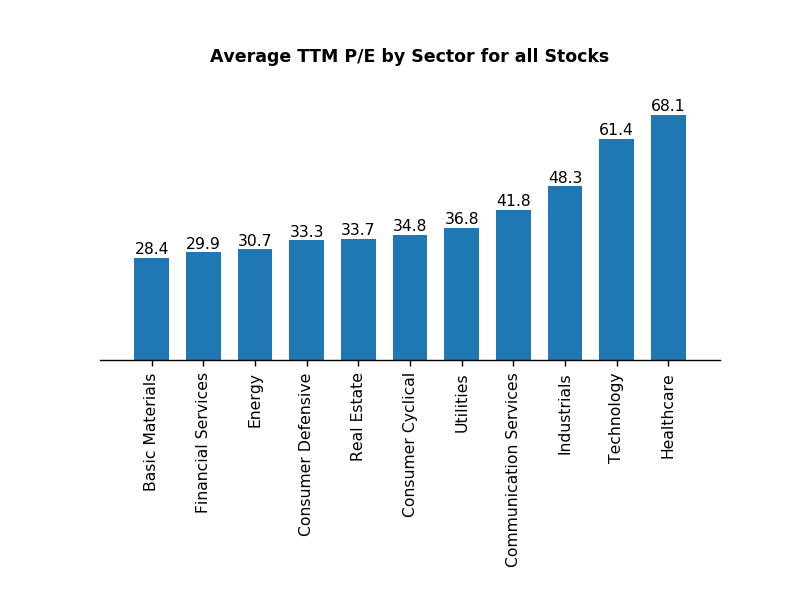

In [145]:
fig_pe, ax_pe = plt.subplots(1)
x = [x*3 for x in range(len(pe))]
y = pe.sort_values(ascending=True)
bars = ax_pe.bar(x, y, width=2)
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
for tick in ax_pe.xaxis.get_ticklabels():
    tick.set_rotation(90)
plt.subplots_adjust(bottom=0.4)
plt.title('Average TTM P/E by Sector for all Stocks', fontsize=10, fontweight='bold')
plt.yticks([])
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
plt.axis([-3, len(x)*3, 0, 80])
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)

*USA*

In [140]:
pe = df_valuation_mean_usa['PE_TTM']

<IPython.core.display.Javascript object>


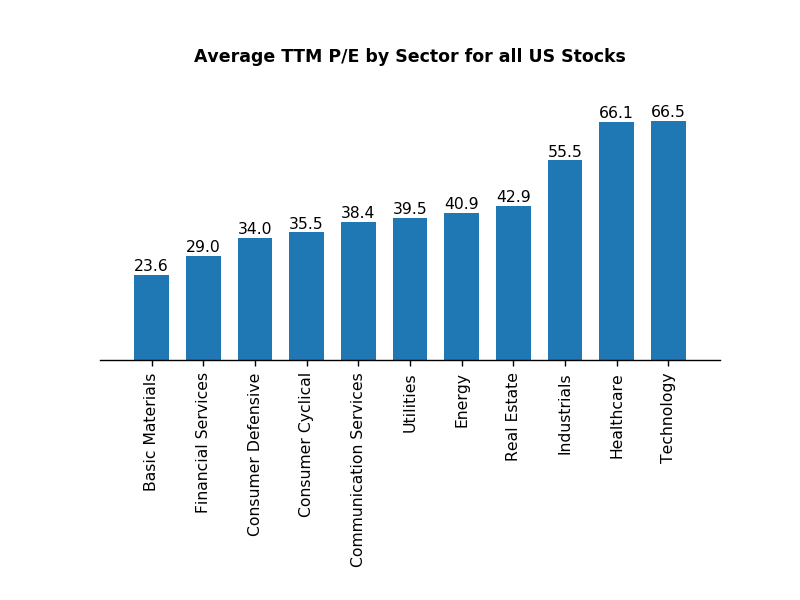

In [141]:
fig_pe, ax_pe = plt.subplots(1)
x = [x*3 for x in range(len(pe))]
y = pe.sort_values(ascending=True)
bars = ax_pe.bar(x, y, width=2)
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
for tick in ax_pe.xaxis.get_ticklabels():
    tick.set_rotation(90)
plt.subplots_adjust(bottom=0.4)
plt.title('Average TTM P/E by Sector for all US Stocks', fontsize=10, fontweight='bold')
plt.yticks([])
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
plt.axis([-3, len(x)*3, 0, 80])
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)

*DEU*

In [142]:
pe = df_valuation_mean_deu['PE_TTM']

<IPython.core.display.Javascript object>


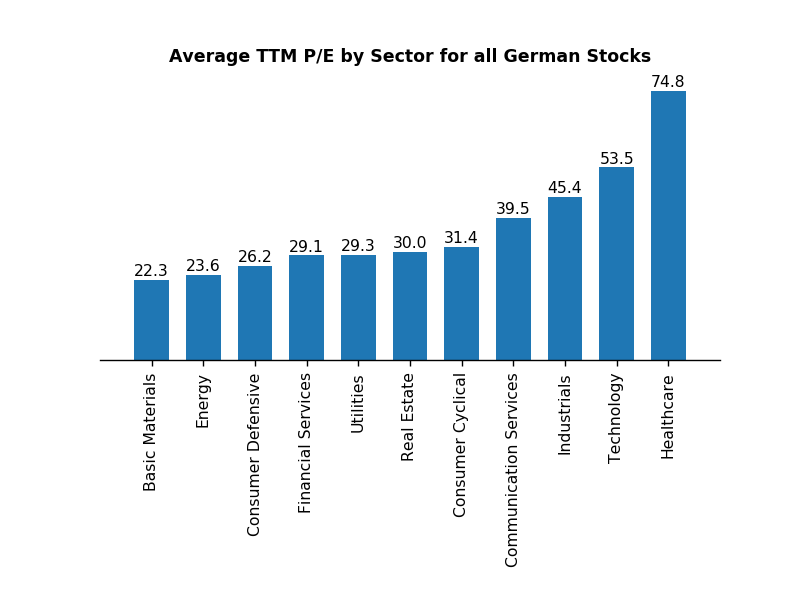

In [143]:
fig_pe, ax_pe = plt.subplots(1)
x = [x*3 for x in range(len(pe))]
y = pe.sort_values(ascending=True)
bars = ax_pe.bar(x, y, width=2)
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
for tick in ax_pe.xaxis.get_ticklabels():
    tick.set_rotation(90)
plt.subplots_adjust(bottom=0.4)
plt.title('Average TTM P/E by Sector for all German Stocks', fontsize=10, fontweight='bold')
plt.yticks([])
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
plt.axis([-3, len(x)*3, 0, 80])
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)

### Stocks in the Cannabis Industry
Using stocks listed on [marijuanaindex.com](http://marijuanaindex.com/stock-quotes/north-american-marijuana-index/) under North America

In [150]:
import json

with open('input/pot_stocks.json') as file:
    pot_symbols = json.loads(file.read())
    
pot_stocks = (pd.DataFrame(pot_symbols, columns=['ticker', 'country_c3'])
               .merge(df_master, how='left', on=['ticker', 'country_c3']).drop('country', axis=1)
               .rename(columns={'country_c3':'country', 'exchange_sym':'exch'}))

pot_stocks = (pot_stocks.where(((pot_stocks['country'] == 'USA') | 
                                (pot_stocks['country'] == 'CAN')) &
                               (pot_stocks['sector'] != '—'))
              .dropna(axis=0, how='all').sort_values(by='company'))

In [151]:
msg = 'Below are the {} stocks listed on marijuanaindex.com for North America.'
print(msg.format(len(pot_stocks['company'].unique())))

pot_stocks[['country', 'ticker', 'exch', 'company', 'sector', 'industry']]

Below are the 46 stocks listed on marijuanaindex.com for North America.


,country,ticker,exch,company,sector,industry
29,CAN,TGIF,XCNQ,1933 Industries Inc,Healthcare,Drug Manufacturers - Specialty & Generic
1,USA,ACRGF,PINX,Acreage Holdings Inc Ordinary Shares (Sub Voting),Healthcare,Drug Manufacturers - Specialty & Generic
2,CAN,ACRG.U,XCNQ,Acreage Holdings Inc Ordinary Shares (Sub Voting),Healthcare,Drug Manufacturers - Specialty & Generic
37,USA,APHA,XNYS,Aphria Inc,Healthcare,Drug Manufacturers - Specialty & Generic
0,CAN,ACB,XTSE,Aurora Cannabis Inc,Healthcare,Drug Manufacturers - Specialty & Generic
36,CAN,XLY,XTSX,Auxly Cannabis Group Inc,Healthcare,Drug Manufacturers - Specialty & Generic
40,USA,CVSI,PINX,CV Sciences Inc,Healthcare,Drug Manufacturers - Specialty & Generic
32,CAN,TRST,XTSE,CannTrust Holdings Inc,Healthcare,Drug Manufacturers - Specialty & Generic
4,CAN,CNNX,XCNQ,Cannex Capital Holdings Inc,Healthcare,Drug Manufacturers - Specialty & Generic
38,USA,CGC,XNYS,Canopy Growth Corp,Healthcare,Drug Manufacturers - Specialty & Generic


<a id="value"></a>
[return to the top](#top)

## Applying value investing criteria to filter common stocks

- **[Rule 1](#rule1): No earnings deficit (loss) for past 5 years**
- **[Rule 2](#rule2): Uniterrupted and increasing Dividends for past 5 yrs**
- **[Rule 3](#rule3): P/E Ratio of 25 or less for the past 7 yrs and less then 20 for TTM¶**
- **[Rule 4](#rule4): P/B Ratio of 1 or less for TTM**
- **[Rule 5](#rule5): Filter for "bargain issues"**
- **[Rule 6](#rule5): **
- **[Rule 7](#rule5): **
- **[Rule 8](#rule5): **
<a id="rule1"></a>

### Rule 1. No earnings deficit (loss) for past 5 years

**a. Identify *Net Income* column labels in** `df_annualIS`

In [94]:
data = 'Net income'
df_labels = df_labels_aIS[df_labels_aIS['value'] == data].sort_values(by='value')
df_labels

,value
header,
label_i50,Net income
label_i70,Net income
label_i80,Net income


**b. Get column headers for 'Net income' values for the past 5 yrs**

In [95]:
i_ids = [(label[-3:] + '_') for label in df_labels.index]

def get_icols(col):
    for i_id in i_ids:
        if i_id in col:
            return True
    return False

main_cols1 = ['ticker_id', 'exchange_id', 
             'country', 'exchange_sym', 'ticker', 'company', 
             'sector', 'industry', 'stock_type', 'style', 
             'Y6', 'Y5', 'Y4', 'Y3', 'Y2', 'Y1']
data_cols = sorted(list(filter(get_icols, df_annualIS.columns)), key=lambda r: (r[-1], r[5:8]), reverse=True)
print('The following columns contain \'{}\' values:\n{}'.format(data, data_cols))

The following columns contain 'Net income' values:
['data_i80_Y_6', 'data_i70_Y_6', 'data_i50_Y_6', 'data_i80_Y_5', 'data_i70_Y_5', 'data_i50_Y_5', 'data_i80_Y_4', 'data_i70_Y_4', 'data_i50_Y_4', 'data_i80_Y_3', 'data_i70_Y_3', 'data_i50_Y_3', 'data_i80_Y_2', 'data_i70_Y_2', 'data_i50_Y_2', 'data_i80_Y_1', 'data_i70_Y_1', 'data_i50_Y_1']


**c. Create 'Net Income' DataFrame**

In [96]:
df_netinc5 = (df_annualIS
              .where((df_annualIS['security_type'] == 'Stock') & 
                     (df_annualIS['Y5'] >= pd.to_datetime('2018-01')))
              .dropna(axis=0, how='all')
              .drop(['country'], axis=1)
              .rename(columns={'country_c3':'country'})
             )[main_cols1 + data_cols]

np_netinc = df_netinc5[data_cols].values
netinc_cols = [('Net_Income_Y' + data_cols[i * 3][-1], (i * 3, i * 3 + 1, i * 3 + 2))
               for i in range(int(len(data_cols)/3))]

vals = []
for row in np_netinc:
    row_vals = []
    for i in range(len(netinc_cols)):
        val = None
        for col in netinc_cols[i][1]:
            if not np.isnan(row[col]):
                val = row[col]
                break
        row_vals.append(val)
    vals.append(row_vals)
    
df_vals = pd.DataFrame(vals, columns=list(zip(*netinc_cols))[0])
df_netinc5 = df_netinc5[main_cols1].join(df_vals)

In [97]:
df_rule1 = df_netinc5.where((df_netinc5['Net_Income_Y6'] > 0) & 
                            ((df_netinc5['Net_Income_Y5'] > 0) | (df_netinc5['Net_Income_Y5'].isna())) & 
                            ((df_netinc5['Net_Income_Y4'] > 0) | (df_netinc5['Net_Income_Y4'].isna())) & 
                            ((df_netinc5['Net_Income_Y3'] > 0) | (df_netinc5['Net_Income_Y3'].isna())) & 
                            ((df_netinc5['Net_Income_Y2'] > 0) | (df_netinc5['Net_Income_Y2'].isna())) & 
                            ((df_netinc5['Net_Income_Y1'] > 0) | (df_netinc5['Net_Income_Y1'].isna()))
                           ).dropna(axis=0, how='all')

In [98]:
df_rule1

,ticker_id,exchange_id,country,exchange_sym,ticker,company,sector,industry,stock_type,style,...,Y4,Y3,Y2,Y1,Net_Income_Y6,Net_Income_Y5,Net_Income_Y4,Net_Income_Y3,Net_Income_Y2,Net_Income_Y1
0,1.0,374.0,USA,ARCX,OGCP,Empire State Realty OP LP Operating Partnershi...,Real Estate,REIT - Diversified,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.164020e+08,1.164020e+08,1.182530e+08,1.072500e+08,7.992800e+07,7.021000e+07
1,2.0,374.0,USA,ARCX,FISK,Empire State Realty OP LP Operating Partnershi...,Real Estate,REIT - Diversified,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.164020e+08,1.164020e+08,1.182530e+08,1.072500e+08,7.992800e+07,7.021000e+07
2,3.0,374.0,USA,ARCX,ESBA,Empire State Realty OP LP Operating Partnershi...,Real Estate,REIT - Diversified,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.164020e+08,1.164020e+08,1.182530e+08,1.072500e+08,7.992800e+07,7.021000e+07
4,19275.0,302.0,USA,XNYS,LPT,Liberty Property Trust,Real Estate,REIT - Office,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,4.796070e+08,4.796070e+08,2.823400e+08,3.568170e+08,2.380390e+08,2.179100e+08
6,19849.0,302.0,USA,XNYS,DEI,Douglas Emmett Inc,Real Estate,REIT - Office,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.160860e+08,1.160860e+08,9.444300e+07,8.539700e+07,5.838400e+07,4.462100e+07
7,19240.0,302.0,USA,XNYS,KRC,Kilroy Realty Corp,Real Estate,REIT - Office,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,2.584150e+08,2.584150e+08,1.646120e+08,2.937880e+08,2.340810e+08,1.802190e+08
8,19993.0,302.0,USA,XNYS,PEB,Pebblebrook Hotel Trust,Real Estate,REIT - Hotel & Motel,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.339300e+07,1.339300e+07,9.988800e+07,7.370400e+07,9.466800e+07,7.286600e+07
9,19335.0,302.0,USA,XNYS,MAA,Mid-America Apartment Communities Inc,Real Estate,REIT - Residential,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,2.228990e+08,2.228990e+08,3.283790e+08,2.122220e+08,3.322870e+08,1.479800e+08
10,19694.0,302.0,USA,XNYS,UDR,UDR Inc,Real Estate,REIT - Residential,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,2.031060e+08,2.031060e+08,1.215580e+08,2.927180e+08,3.403830e+08,1.543340e+08
11,19021.0,302.0,USA,XNYS,EGP,EastGroup Properties Inc,Real Estate,REIT - Industrial,Hard Asset,Mid Core,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,8.850600e+07,8.850600e+07,8.318300e+07,9.550900e+07,4.786600e+07,4.794100e+07


[return to top of this section](#value),
[return to the top](#top)
<a id="rule2"></a>
### Rule 2. Uniterrupted and increasing *Dividends* for past 7 yrs

**a. Identify *Dividends* column label in** `df_keyratios`

In [109]:
icol = df_labels_kratios[df_labels_kratios == 'Dividends'].index[0]
icol

'i6'

**b. Get column headers for *Dividends* for the past 5 yrs**

In [110]:
main_cols2 = ['ticker_id', 'exchange_id', 
             #'country_c3', 'exchange_sym', 'ticker', 'company', 
             #'sector', 'industry', 'stock_type', 'style', 
             'Y10', 'Y9', 'Y8', 'Y7', 'Y6', 'Y5']
icols = sorted([col for col in df_keyratios.columns if icol + '_' in col], 
               key=lambda col: int(col[4:]), reverse=True)[:8]
icols

['i6_Y10', 'i6_Y9', 'i6_Y8', 'i6_Y7', 'i6_Y6', 'i6_Y5', 'i6_Y4', 'i6_Y3']

**c. Create 'Net Income' DataFrame**

In [111]:
df_rule2 = (df_keyratios
            .where((df_keyratios['security_type'] == 'Stock') & 
                   (df_keyratios['Y9'] >= pd.to_datetime('2018-01')) & 
                   (df_keyratios['i6_Y10'].notna()) & (df_keyratios['i6_Y9'].notna()) &
                   (df_keyratios['i6_Y8'].notna()) & (df_keyratios['i6_Y7'].notna()) &
                   (df_keyratios['i6_Y6'].notna()) & (df_keyratios['i6_Y5'].notna()) & 
                   (df_keyratios['i6_Y4'].notna()) & (df_keyratios['i6_Y3'].notna()) & 
                   (df_keyratios['i6_Y10'] >= df_keyratios['i6_Y9']) & 
                   (df_keyratios['i6_Y9'] >= df_keyratios['i6_Y8']) & 
                   (df_keyratios['i6_Y8'] >= df_keyratios['i6_Y7']) & 
                   (df_keyratios['i6_Y7'] >= df_keyratios['i6_Y6']) & 
                   (df_keyratios['i6_Y6'] >= df_keyratios['i6_Y5']) & 
                   (df_keyratios['i6_Y5'] >= df_keyratios['i6_Y4']) & 
                   (df_keyratios['i6_Y4'] >= df_keyratios['i6_Y3']))
            .dropna(axis=0, how='all').sort_values(by='Y9', ascending=False))[main_cols2 + icols]

df_rule2.columns = main_cols2 + [col.replace('i6', 'Dividend') for col in icols]

In [112]:
df_rule2

,ticker_id,exchange_id,Y10,Y9,Y8,Y7,Y6,Y5,Dividend_Y10,Dividend_Y9,Dividend_Y8,Dividend_Y7,Dividend_Y6,Dividend_Y5,Dividend_Y4,Dividend_Y3
63894,19249.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,2.44,2.44,2.20,2.00,1.80,1.56,1.40,1.28
68154,19649.0,141.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,2.15,2.15,1.95,1.75,1.58,1.48,1.34,1.25
34106,19106.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,0.97,0.97,0.92,0.92,0.92,0.88,0.70,0.50
34105,19393.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,1.48,1.48,1.48,1.48,1.48,1.32,1.20,1.08
34103,18701.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,0.55,0.55,0.50,0.50,0.50,0.50,0.38,0.33
63895,19276.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,2.40,2.40,2.40,2.40,2.00,1.36,1.20,1.00
63900,18891.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,0.34,0.34,0.33,0.32,0.31,0.30,0.24,0.21
68156,19649.0,142.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,2.15,2.15,1.95,1.75,1.58,1.48,1.34,1.25
68153,19649.0,17.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,2.15,2.15,1.95,1.75,1.58,1.48,1.34,1.25
68152,19649.0,16.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,2.15,2.15,1.95,1.75,1.58,1.48,1.34,1.25


[return to top of this section](#value),
[return to the top](#top)
<a id="rule3"></a>
### Rule 3. P/E Ratio of 25 or less for the past 7 yrs and less then 20 for TTM

In [113]:
pe_cols = [col for col in df_valuation.columns if 'PE_' in col]
pe_cols = [pe_cols[len(pe_cols)-i-1] for i in range(len(pe_cols))][:8]
pe_cols

['PE_TTM',
 'PE_2018',
 'PE_2017',
 'PE_2016',
 'PE_2015',
 'PE_2014',
 'PE_2013',
 'PE_2012']

In [114]:
df_rule3 = (df_vals[['ticker_id', 'exchange_id'] + pe_cols]
            .where((df_vals['PE_TTM'] <= 20) & (df_vals['PE_2018'] <= 25) &
                   (df_vals['PE_2017'] <= 25) & (df_vals['PE_2016'] <= 25) &
                   (df_vals['PE_2015'] <= 25) & (df_vals['PE_2014'] <= 25) &
                   (df_vals['PE_2013'] <= 25) & (df_vals['PE_2012'] <= 25)).dropna(axis=0, how='all'))

In [115]:
df_rule3

,ticker_id,exchange_id,PE_TTM,PE_2018,PE_2017,PE_2016,PE_2015,PE_2014,PE_2013,PE_2012
643,644.0,1.0,14.3,15.0,15.2,15.1,13.6,17.7,11.8,10.4
700,704.0,1.0,6.4,5.4,9.0,15.5,14.5,14.7,17.1,16.2
878,885.0,1.0,17.2,16.2,20.4,21.4,18.3,15.2,14.1,14.5
888,895.0,1.0,8.1,7.3,8.2,7.2,11.7,14.9,24.3,17.8
946,954.0,1.0,5.1,4.4,14.3,9.1,3.5,6.4,4.5,5.2
1054,1063.0,17.0,5.6,4.3,9.4,11.0,6.6,6.4,6.0,12.4
1055,1063.0,141.0,5.3,4.2,8.8,10.6,6.3,6.9,6.7,13.6
1080,1087.0,1.0,3.4,4.1,7.4,5.8,4.7,5.0,6.4,6.0
1144,1152.0,1.0,11.0,12.2,12.9,13.3,18.9,8.5,4.4,4.7
1149,1158.0,1.0,14.1,10.9,16.5,15.9,16.1,15.3,13.6,8.0


[return to top of this section](#value),
[return to the top](#top)
<a id="rule4"></a>
### Rule 4. P/B Ratio of 1 or less for TTM

In [117]:
pb_cols = [col for col in df_vals.columns if 'PB_' in col]
pb_cols = [pb_cols[len(pb_cols)-i-1] for i in range(len(pb_cols))][:6]
pb_cols

['PB_TTM', 'PB_2018', 'PB_2017', 'PB_2016', 'PB_2015', 'PB_2014']

In [118]:
df_rule4 = (df_vals[['ticker_id', 'exchange_id'] + pb_cols]
            .where(df_vals['PB_TTM'] <= 1).dropna(axis=0))

In [119]:
df_rule4

,ticker_id,exchange_id,PB_TTM,PB_2018,PB_2017,PB_2016,PB_2015,PB_2014
144,139.0,1.0,0.6,0.6,0.7,0.2,0.6,0.8
148,143.0,1.0,0.1,0.1,0.3,0.6,0.2,0.5
308,302.0,1.0,0.9,1.0,3.6,-14.1,0.9,0.1
340,335.0,1.0,0.7,0.6,1.8,0.3,0.2,0.8
366,361.0,1.0,0.5,0.5,1.2,0.9,2.1,8.5
400,396.0,1.0,0.5,0.6,1.4,2.8,5.1,4.5
601,602.0,1.0,0.3,0.4,0.9,2.4,0.2,0.2
672,675.0,1.0,0.7,0.6,1.5,2.1,1.7,3.1
686,689.0,1.0,0.2,0.1,0.8,0.9,0.7,1.0
688,691.0,1.0,0.3,0.3,0.7,0.9,1.4,1.1


[return to top of this section](#value),
[return to the top](#top)
<a id="rule5"></a>
### Rule 5. Filtering for *bargain issues* as described by Benjamin Graham in *The Intelligent Investor*:

In his book, Graham defines bargain issues as common stocks where:

- $stock\ price\ = \frac{2}{3}\ net\ current\ asset\ value\ per\ share\ (NCAVPS)\$

- $net\ current\ asset\ value\ (NCAV)\ = current\ assets\ - total\ liabilities\ - preferred\ stocks\$

[return to top of this section](#value),
[return to the top](#top)
<a id="rule6"></a>
### Rule 6. Operating Cash Flow growth for the past 7 yrs

[return to top of this section](#value),
[return to the top](#top)
<a id="rule7"></a>
### Rule 7. *Owner earnings* growth rate > 6% over past 7 years

$owner\ earning's = net\ income + amortization\ and\ depreciation\ - normal\ capital\ expenditures$

Benjamin Graham mentions in *Intelligent Investor* that, because it adjusts for entries like amortization and depreciation that do not affect the company's cash balances, *owner earnings* is a better measure to reported net income. 

[return to top of this section](#value),
[return to the top](#top)
<a id="rule8"></a>
### Rule 8. Long-term debt < 50% of total capital

[return to top of this section](#value),
[return to the top](#top)
<a id="rule9"></a>
### Rule 9. NAV per share > Stock Price

The definition of NAV as described by Graham in the Intelligent Investor

$net\ asset\ value\ (NAV)\ = total\ assets\ - intangible\ assets\ (patents,\ goodwill)\ - total\ liabilities\$

[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. Positive ratio of earnings to fixed charges

### Merging DataFrames

In [49]:
df_rules = (df_rule1
            .merge(df_rule2, on=['ticker_id', 'exchange_id'])
            .merge(df_rule3, on=['ticker_id', 'exchange_id'])
            .merge(df_rule4, on=['ticker_id', 'exchange_id'])
           )

In [50]:
df_rules.columns.values

array(['ticker_id', 'exchange_id', 'country', 'exchange_sym', 'ticker',
       'company', 'sector', 'industry', 'stock_type', 'style', 'Y6_x',
       'Y5_x', 'Y4', 'Y3', 'Y2', 'Y1', 'Net_Income_Y6', 'Net_Income_Y5',
       'Net_Income_Y4', 'Net_Income_Y3', 'Net_Income_Y2', 'Net_Income_Y1',
       'Y10', 'Y9', 'Y8', 'Y7', 'Y6_y', 'Y5_y', 'Dividend_Y10',
       'Dividend_Y9', 'Dividend_Y8', 'Dividend_Y7', 'Dividend_Y6',
       'Dividend_Y5', 'PE_TTM', 'PE_2018', 'PE_2017', 'PE_2016',
       'PE_2015', 'PE_2014', 'PB_TTM', 'PB_2018', 'PB_2017', 'PB_2016',
       'PB_2015', 'PB_2014'], dtype=object)

In [51]:
df_rules.groupby('company').count()['ticker_id']

company
AP (Thailand) PCL DR                                                     2
APT Satellite Holdings Ltd                                               1
Acme United Corp                                                         1
Air Lease Corp Class A                                                   2
Aircastle Ltd                                                            3
Akbank TAS ADR                                                           3
Anhui Expressway Co Ltd Class H                                          4
Anhui Expressway Co Ltd H Shares                                         1
Apollo Commercial Real Estate Finance Inc                                1
Ares Capital Corp                                                        1
Ares Commercial Real Estate Corp                                         1
Associated Banc-Corp                                                     1
Assured Guaranty Ltd                                                     4
BTB Real Estate I

<a id="additional"></a>
[return to the top](#top)

## Additional sample / test code

In [16]:
df = None # Set df variable to none to close db connection 

Database connection for file db/mstables2.sqlite closed.
